# Adult Census Income / 国税調査からの収入予測
【練習問題】国勢調査からの収入予測

教育年数や職業等の国勢調査データから年収が$50,000ドルを超えるかどうかを予測しよう。

https://signate.jp/competitions/107/

# ライブラリ

In [1]:
import os  # OS操作のためのライブラリ
import random  # ランダムな数値を生成するためのライブラリ
import numpy as np  # 数値計算のためのライブラリ
import pandas as pd  # データ分析のためのライブラリ

# データの可視化のためのライブラリ
import seaborn as sns  # 高度なデータ可視化のためのライブラリ
import matplotlib.pyplot as plt  # 基本的なデータ可視化のためのライブラリ
# Jupyter Notebookでグラフを表示するためのマジックコマンド
%matplotlib inline

# 機械学習のためのライブラリ
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder # データの前処理のための関数
from sklearn.model_selection import train_test_split, StratifiedKFold  # データ分割と交差検証のための関数
from sklearn.metrics import accuracy_score, confusion_matrix  # モデルの評価のための関数

# 機械学習のフレームワーク
import lightgbm as lgb

Google Driveの中にあるファイルを読み込むため、Google Driveのマウントを行う。

参考： https://blog.kikagaku.co.jp/google-colab-drive-mount

In [2]:
# Google Colabのライブラリをインポートする
from google.colab import drive

# Google DriveをColab上にマウントする
# 実行すると認証のためのリンクが表示されるので、リンクをクリックして認証を行い、
# 表示されるコードをコピーして、Colabの入力ボックスにペーストする
drive.mount('/content/drive/')

Mounted at /content/drive/


設定をまとめて行う。

In [3]:
# 交差検証時の分割数を設定
N_SPLITS = 5

# pandasのオプションを設定して、表示される最大列数を100に変更
# これにより、大きなデータフレームでも最初の100列までが表示される
pd.options.display.max_columns = 100

# seabornのグラフの色を'pastel'に設定
sns.set_palette('pastel')

# 乱数の固定のための関数とシード値の設定
SEED = 42

def seed_everything(seed=1234):
    """
    乱数を固定するための関数。

    Parameters:
    - seed (int): 乱数のシード値。デフォルトは1234。
    """
    random.seed(seed)  # Pythonのrandomモジュールの乱数を固定
    os.environ['PYTHONHASHSEED'] = str(seed)  # Pythonのハッシュの乱数を固定
    np.random.seed(seed)  # numpyの乱数を固定

# 上で定義した関数を使用して、乱数を固定
seed_everything(SEED)

# SIGNATEっぽいデータを作る
SIGNATEのデータは目的以外の使用ができないため、kaggleのデータをもとに似たようなデータを作る。

https://www.kaggle.com/datasets/uciml/adult-census-income

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

このデータは、Ronny KohaviとBarry Becker（Data Mining and Visualization, Silicon Graphics）によって1994年の国勢調査局のデータベースから抽出された。(AAGE>16)&&(AGI>100)&&(AFNLWGT>1)&&(HRSWK>0))。予測タスクは、その人が年収5万ドル以上かどうかを判断することである。

ライセンスは CC0: Public Domain

In [4]:
# kaggleからのデータを読み込む
# 注意: ファイルの場所は自分の環境に合わせて修正すること
adult = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/share/adult.csv')

# データフレームのインデックスをリセットして、新しい列として追加
adult = adult.reset_index()

# データをランダムに並び替える
adult = adult.sample(frac=1, random_state=SEED)

# データフレームの列名を変更
adult.columns = [
    'id', 'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'Y']

# データを訓練データとテストデータに分割
train = adult[:16280]
test = adult[16280:]

# データをidでソート
train = train.sort_values('id')
test = test.sort_values('id')

# テストデータから正解ラベルを取得し、テストデータからはその列を削除
actual = test['Y']
test.drop(columns=['Y'], inplace=True)

# 訓練データとテストデータをTSVファイルとして保存
# 注意: ファイルの保存場所は自分の環境に合わせて修正すること
train.to_csv('/content/drive/MyDrive/Colab_Notebooks/share/train.tsv', sep='\t', index=False)
test.to_csv('/content/drive/MyDrive/Colab_Notebooks/share/test.tsv', sep='\t', index=False)

# データの読込み

In [5]:
# TSVファイルを読み込む
# 注意: ファイルの場所は自分の環境に合わせて修正すること
train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/share/train.tsv', sep='\t', na_values='?')

# 'Y'列の値を数値に変換
# '<=50K'は0に、'>50K'は1に変換する
train = train.replace({'Y': {'<=50K': 0, '>50K': 1}})

# 読み込んだデータフレームを表示
train

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Y
0,0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
1,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
2,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
3,6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0
4,7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,32550,43,State-gov,255835,Some-college,10,Divorced,Adm-clerical,Other-relative,White,Female,0,0,40,United-States,0
16276,32552,32,Private,34066,10th,6,Married-civ-spouse,Handlers-cleaners,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States,0
16277,32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0
16278,32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1


In [6]:
# TSVファイルを読み込む
# 注意: ファイルの場所は自分の環境に合わせて修正すること
test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/share/test.tsv', sep='\t', na_values='?')

# 読み込んだデータフレームを表示
test

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
1,2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States
2,5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States
3,9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN
4,10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States
16277,32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan
16278,32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
16279,32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States


# 探索的データ解析(EDA)

info()

In [7]:
# 'train'データフレームの基本情報を表示
# これにより、各列のデータ型や欠損値の有無などを確認できる
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              16280 non-null  int64 
 1   age             16280 non-null  int64 
 2   workclass       15365 non-null  object
 3   fnlwgt          16280 non-null  int64 
 4   education       16280 non-null  object
 5   education-num   16280 non-null  int64 
 6   marital-status  16280 non-null  object
 7   occupation      15362 non-null  object
 8   relationship    16280 non-null  object
 9   race            16280 non-null  object
 10  sex             16280 non-null  object
 11  capital-gain    16280 non-null  int64 
 12  capital-loss    16280 non-null  int64 
 13  hours-per-week  16280 non-null  int64 
 14  native-country  15981 non-null  object
 15  Y               16280 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.0+ MB


In [8]:
# 'test'データフレームの基本情報を表示
# これにより、各列のデータ型や欠損値の有無などを確認できる
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              16281 non-null  int64 
 1   age             16281 non-null  int64 
 2   workclass       15360 non-null  object
 3   fnlwgt          16281 non-null  int64 
 4   education       16281 non-null  object
 5   education-num   16281 non-null  int64 
 6   marital-status  16281 non-null  object
 7   occupation      15356 non-null  object
 8   relationship    16281 non-null  object
 9   race            16281 non-null  object
 10  sex             16281 non-null  object
 11  capital-gain    16281 non-null  int64 
 12  capital-loss    16281 non-null  int64 
 13  hours-per-week  16281 non-null  int64 
 14  native-country  15997 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.9+ MB


describe()

In [9]:
# 'train'データフレームの数値型の列に対する基本的な統計情報を表示
# これにより、各列の分布や中央値、外れ値の存在などを確認できる
train.describe()

,id,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Y
count,16280.000000,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,16247.282125,38.606880,1.900212e+05,10.074447,1074.572850,87.478010,40.386118,0.240541
std,9397.737279,13.649618,1.055355e+05,2.563066,7362.392932,402.560087,12.257884,0.427425
min,0.000000,17.000000,1.921400e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,8134.250000,28.000000,1.185000e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,16200.500000,37.000000,1.786520e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,24412.250000,48.000000,2.366158e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,32560.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [10]:
# 'test'データフレームの数値型の列に対する基本的な統計情報を表示
# これにより、各列の分布や中央値、外れ値の存在などを確認できる
test.describe()

,id,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,16312.715865,38.556415,1.895356e+05,10.086911,1080.724648,87.129660,40.488791
std,9401.827753,13.631614,1.055671e+05,2.582401,7408.343896,403.372217,12.436488
min,1.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8159.000000,28.000000,1.175070e+05,9.000000,0.000000,0.000000,40.000000
50%,16371.000000,37.000000,1.780540e+05,10.000000,0.000000,0.000000,40.000000
75%,24435.000000,48.000000,2.377350e+05,12.000000,0.000000,0.000000,45.000000
max,32559.000000,90.000000,1.366120e+06,16.000000,99999.000000,4356.000000,99.000000


欠損値の確認

In [11]:
# 'train'データフレームの欠損値の数を表示
missing_count = train.isna().sum()
missing_ratio = (train.isna().sum() / len(train)) * 100
missing_data = pd.DataFrame({'Missing Count': missing_count, 'Missing Ratio (%)': missing_ratio})
missing_data

,Missing Count,Missing Ratio (%)
id,0,0.000000
age,0,0.000000
workclass,915,5.620393
fnlwgt,0,0.000000
education,0,0.000000
education-num,0,0.000000
marital-status,0,0.000000
occupation,918,5.638821
relationship,0,0.000000
race,0,0.000000


In [12]:
# 'test'データフレームの欠損値の数を表示
missing_count = test.isna().sum()
missing_ratio = (test.isna().sum() / len(train)) * 100
missing_data = pd.DataFrame({'Missing Count': missing_count, 'Missing Ratio (%)': missing_ratio})
missing_data

,Missing Count,Missing Ratio (%)
id,0,0.000000
age,0,0.000000
workclass,921,5.657248
fnlwgt,0,0.000000
education,0,0.000000
education-num,0,0.000000
marital-status,0,0.000000
occupation,925,5.681818
relationship,0,0.000000
race,0,0.000000


age / 年齢

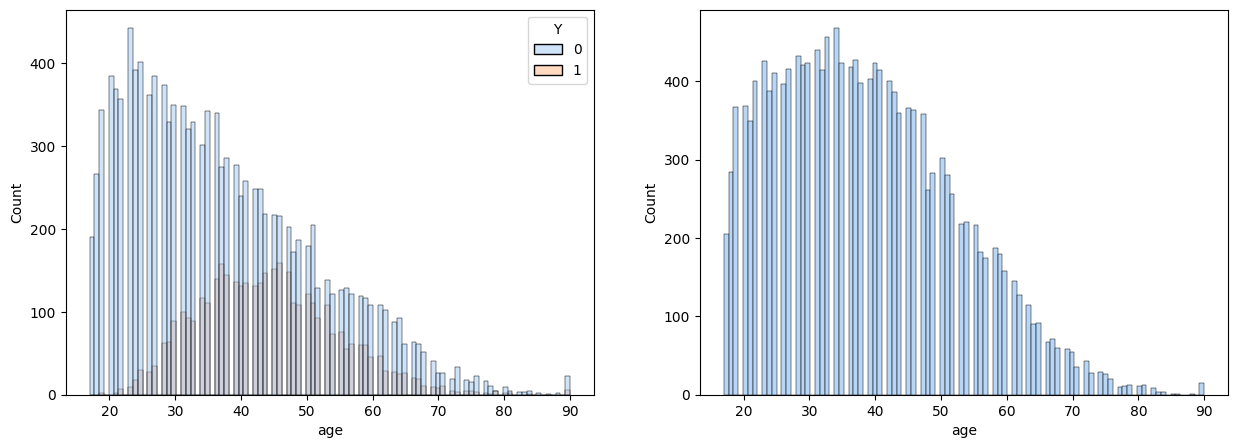

In [13]:
# 描画する列を指定
col = 'age'

# 2つのサブプロットを持つフィギュアを作成
# figsizeはフィギュアのサイズを指定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# trainデータのヒストグラムを描画
# hue='Y'で'Y'列の値に基づいて色分け
sns.histplot(data=train, x=col, hue='Y', bins=100, kde=False, ax=ax1)

# testデータのヒストグラムを描画
sns.histplot(data=test, x=col, bins=100, kde=False, ax=ax2)

# フィギュアを表示
plt.show()

workclass / 職業クラス

In [14]:
# 'train'データフレームの'workclass'列の各ユニークな値の出現回数をカウント
# これにより、'workclass'の各カテゴリのデータの量を確認できる
train['workclass'].value_counts()


Private             11392
Self-emp-not-inc     1243
Local-gov            1037
State-gov             638
Self-emp-inc          543
Federal-gov           502
Without-pay             7
Never-worked            3
Name: workclass, dtype: int64

In [15]:
# 'test'データフレームの'workclass'列の各ユニークな値の出現回数をカウント
# これにより、'workclass'の各カテゴリのデータの量を確認できる
test['workclass'].value_counts()

Private             11304
Self-emp-not-inc     1298
Local-gov            1056
State-gov             660
Self-emp-inc          573
Federal-gov           458
Without-pay             7
Never-worked            4
Name: workclass, dtype: int64

In [16]:
# 'train'データフレームの'workclass'列の各カテゴリに対して、'Y'列の平均値を計算
# これにより、各'workclass'カテゴリの'Y'の平均的な傾向を確認できる
train.groupby('workclass')['Y'].mean()

workclass
Federal-gov         0.382470
Local-gov           0.315333
Never-worked        0.000000
Private             0.219277
Self-emp-inc        0.546961
Self-emp-not-inc    0.272727
State-gov           0.264890
Without-pay         0.000000
Name: Y, dtype: float64

In [17]:
# trainとtestの2つのデータのどちらか一方のみに含まれる要素がないか確認
def compare_categorical_columns(train: pd.DataFrame, test: pd.DataFrame, col_name: str):
    """
    trainとtestのデータフレームの指定されたカラムのカテゴリカル変数を比較する関数

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - col_name: 比較するカラム名

    戻り値:
    - only_in_train: trainだけに存在するカテゴリ
    - only_in_test: testだけに存在するカテゴリ
    """

    # trainとtestからユニークなカテゴリを取得
    train_unique_categories = set(train[col_name].unique())
    test_unique_categories = set(test[col_name].unique())

    # それぞれのデータフレームで独自のカテゴリを特定
    only_in_train = train_unique_categories - test_unique_categories
    only_in_test = test_unique_categories - train_unique_categories

    # 結果を表示
    print('trainのみに存在するカテゴリ:', only_in_train)
    print('trainのカテゴリの要素数:', len(only_in_train))
    print('testのみに存在するカテゴリ:', only_in_test)
    print('testのカテゴリの要素数:', len(only_in_test))

# 関数を使用してカテゴリを比較
compare_categorical_columns(train, test, 'workclass')

trainのみに存在するカテゴリ: set()
trainのカテゴリの要素数: 0
testのみに存在するカテゴリ: set()
testのカテゴリの要素数: 0


fnlwgt / final weight(人口の推計値)

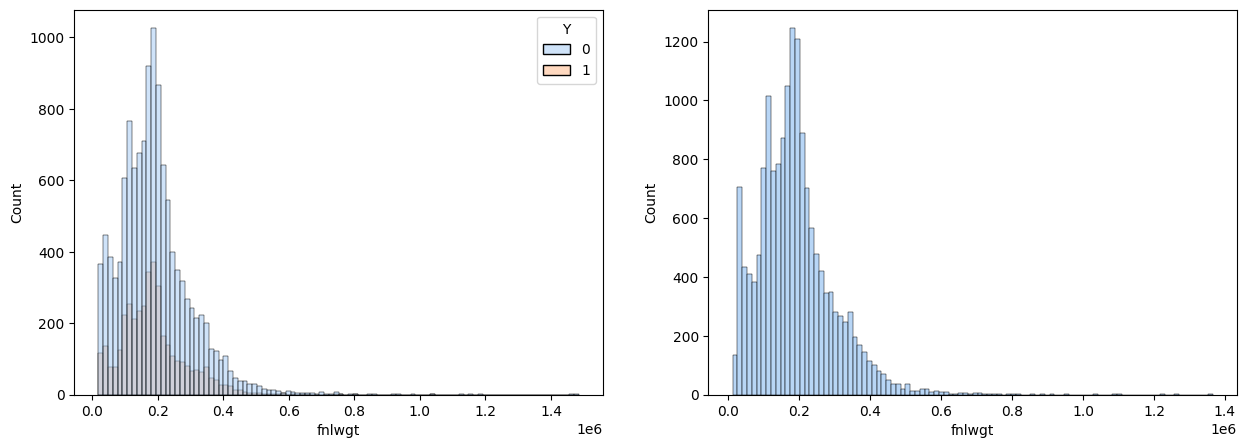

In [18]:
# 描画する列を指定
col = 'fnlwgt'

# 2つのサブプロットを持つフィギュアを作成
# figsizeはフィギュアのサイズを指定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# trainデータのヒストグラムを描画
# hue='Y'で'Y'列の値に基づいて色分け
sns.histplot(data=train, x=col, hue='Y', bins=100, kde=False, ax=ax1)

# testデータのヒストグラムを描画
sns.histplot(data=test, x=col, bins=100, kde=False, ax=ax2)

# フィギュアを表示
plt.show()

# データの前処理

## age / 年齢

量的変数はそのままモデルの入力に用いることができるが、適切な変換・加工を行うことでより有効な特徴となる場合がある。

尚、勾配ブースティングなど決定木をベースにしたモデルではほとんど影響を与えない。

### 標準化

標準化は、データを平均0、分散1に変換する手法。これにより、異なる尺度のデータを同じスケールに揃えることができ、多くの機械学習アルゴリズムの性能を向上させることが期待される。

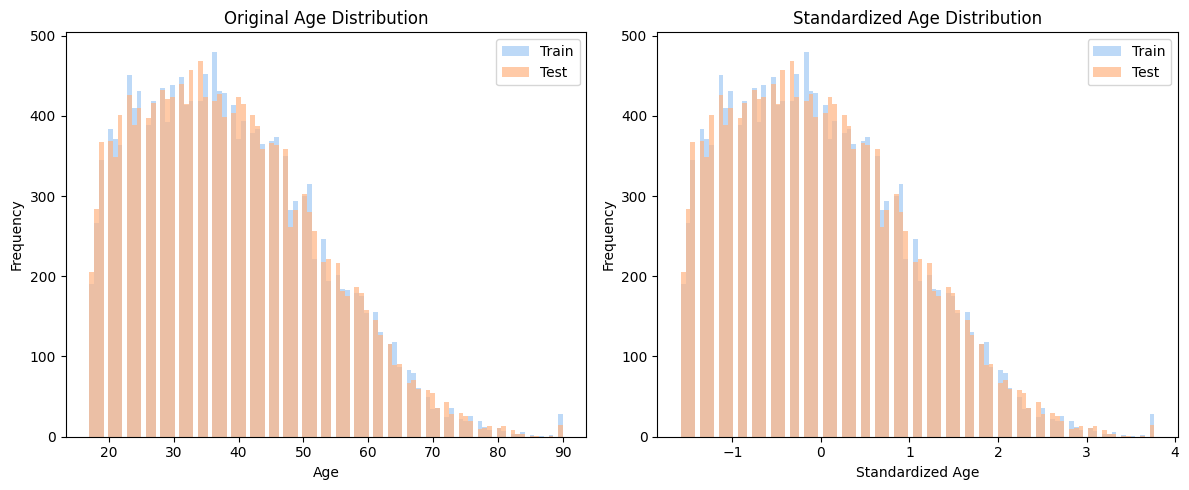

In [19]:
def standardize_column(train: pd.DataFrame, test: pd.DataFrame, column_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    指定されたカラムに対して標準化（平均0、分散1に変換）を行い、
    その結果を新しいカラムとしてtrainとtestデータに追加する関数。

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - column_name: 標準化を適用するカラム名

    戻り値:
    - train: 処理後のトレーニングデータフレーム
    - test: 処理後のテストデータフレーム
    """

    # StandardScalerのインスタンスを作成
    scaler = StandardScaler()

    # trainデータを元にfitし、trainとtestデータをtransform
    train[f"{column_name}_standardized"] = scaler.fit_transform(train[[column_name]])
    test[f"{column_name}_standardized"] = scaler.transform(test[[column_name]])

    return train, test

# 関数を適用して正規化を行う
train, test = standardize_column(train, test, 'age')

# ヒストグラムを表示するための設定
plt.figure(figsize=(12, 5))

# 左側のヒストグラム
plt.subplot(1, 2, 1)
plt.hist(train['age'], bins=100, alpha=0.7, label='Train')
plt.hist(test['age'], bins=100, alpha=0.7, label='Test')
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# 右側のヒストグラム
plt.subplot(1, 2, 2)
plt.hist(train['age_standardized'], bins=100, alpha=0.7, label='Train')
plt.hist(test['age_standardized'], bins=100, alpha=0.7, label='Test')
plt.title('Standardized Age Distribution')
plt.xlabel('Standardized Age')
plt.ylabel('Frequency')
plt.legend()

# ヒストグラムを表示
plt.tight_layout()
plt.show()

### 正規化

正規化は、データを一定の範囲内にスケーリングする手法。0から1の範囲に変換するのが一般的。これにより、異なる尺度のデータが比較しやすくなる。具体的には、データから最小値を引き、その後、最大値と最小値の差で割ることで正規化を行う。

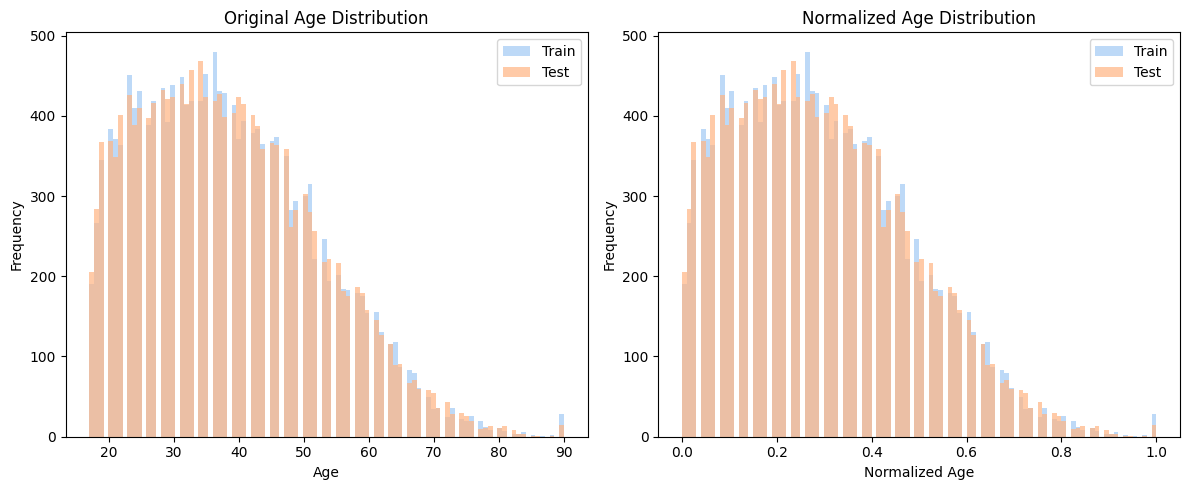

In [20]:
from sklearn.preprocessing import MinMaxScaler

def normalize_column(train: pd.DataFrame, test: pd.DataFrame, column_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    指定されたカラムに対して正規化（0〜1の範囲に変換）を行い、
    その結果を新しいカラムとしてtrainとtestデータに追加する関数。

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - column_name: 正規化を適用するカラム名

    戻り値:
    - train: 処理後のトレーニングデータフレーム
    - test: 処理後のテストデータフレーム
    """

    # MinMaxScalerのインスタンスを作成
    scaler = MinMaxScaler()

    # trainデータを元にfitし、trainとtestデータをtransform
    train[f"{column_name}_normalized"] = scaler.fit_transform(train[[column_name]])
    test[f"{column_name}_normalized"] = scaler.transform(test[[column_name]])

    return train, test

# 関数を適用して正規化を行う
train, test = normalize_column(train, test, 'age')

# ヒストグラムを表示するための設定
plt.figure(figsize=(12, 5))

# 左側のヒストグラム
plt.subplot(1, 2, 1)
plt.hist(train['age'], bins=100, alpha=0.7, label='Train')
plt.hist(test['age'], bins=100, alpha=0.7, label='Test')
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# 右側のヒストグラム
plt.subplot(1, 2, 2)
plt.hist(train['age_normalized'], bins=100, alpha=0.7, label='Train')
plt.hist(test['age_normalized'], bins=100, alpha=0.7, label='Test')
plt.title('Normalized Age Distribution')
plt.xlabel('Normalized Age')
plt.ylabel('Frequency')
plt.legend()

# ヒストグラムを表示
plt.tight_layout()
plt.show()

### 対数化

対数化は、データの範囲を狭めて分布を均一にする手法。例えば、収入のように範囲が広いデータを対数で変換すると、大きな値の影響が減少し、モデルが学習しやすくなる。

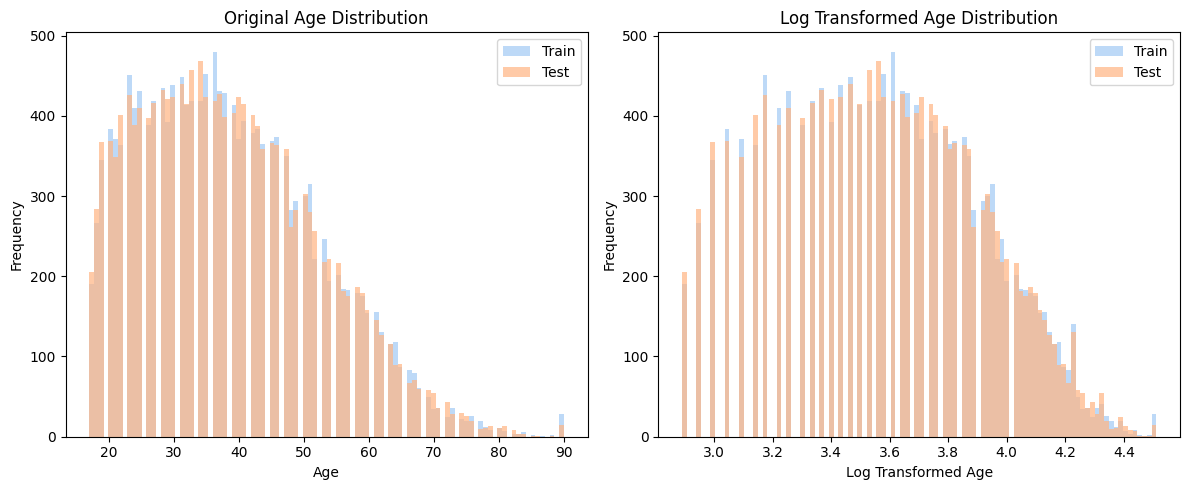

In [21]:
def log_transform_column(train: pd.DataFrame, test: pd.DataFrame, column_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    指定されたカラムに対して対数変換を行い、
    その結果を新しいカラムとしてtrainとtestデータに追加する関数。

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - column_name: 対数変換を適用するカラム名

    戻り値:
    - train: 処理後のトレーニングデータフレーム
    - test: 処理後のテストデータフレーム
    """

    # trainとtestデータの指定されたカラムを対数化
    # +1して、0の場合の対数を取るエラーを防ぐ
    train[f"{column_name}_log_transformed"] = np.log1p(train[column_name])
    test[f"{column_name}_log_transformed"] = np.log1p(test[column_name])

    return train, test

# 関数を適用して対数変換を行う
train, test = log_transform_column(train, test, 'age')

# ヒストグラムを表示するための設定
plt.figure(figsize=(12, 5))

# 左側のヒストグラム
plt.subplot(1, 2, 1)
plt.hist(train['age'], bins=100, alpha=0.7, label='Train')
plt.hist(test['age'], bins=100, alpha=0.7, label='Test')
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# 右側のヒストグラム
plt.subplot(1, 2, 2)
plt.hist(train['age_log_transformed'], bins=100, alpha=0.7, label='Train')
plt.hist(test['age_log_transformed'], bins=100, alpha=0.7, label='Test')
plt.title('Log Transformed Age Distribution')
plt.xlabel('Log Transformed Age')
plt.ylabel('Frequency')
plt.legend()

# ヒストグラムを表示
plt.tight_layout()
plt.show()

## workclass / 職業クラス

カテゴリカル変数であるworkclassはこのままでは学習に使用できないので、量的変数に変換する。

### 欠損値の処理

最頻値で欠損値を補完

In [22]:
# trainデータのworkclass列の最頻値を取得
mode_value_train = train['workclass'].mode()[0]

# trainのworkclass列の欠損値を最頻値で補完
train['workclass'].fillna(mode_value_train, inplace=True)

# testデータのworkclass列の最頻値を取得
mode_value_test = test['workclass'].mode()[0]

# testのworkclass列の欠損値を最頻値で補完
test['workclass'].fillna(mode_value_test, inplace=True)


欠損値の割合が高い場合は他の値で補完しない場合もある

```
# trainとtestのworkclass列の欠損値を'Unknown'で補完
train['workclass'].fillna('Unknown', inplace=True)
test['workclass'].fillna('Unknown', inplace=True)
```

### カウントエンコーディング

各カテゴリの出現回数（カウント）をそのカテゴリの新しい数値として使用。

In [23]:
def count_encode_column(train: pd.DataFrame, test: pd.DataFrame, column_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    指定されたカラムに対して、trainデータのカテゴリの出現回数を基にCount Encodingを適用し、
    その結果を新しいカラムとしてtrainとtestデータに追加する関数。

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - column_name: Count Encodingを適用するカラム名

    戻り値:
    - train: 処理後のトレーニングデータフレーム
    - test: 処理後のテストデータフレーム
    """

    # trainデータの指定されたカラムの各カテゴリの出現回数を計算
    count_encode = train[column_name].value_counts()

    # trainデータとtestデータの指定されたカラムをCount Encodeで変換
    train[f'{column_name}_count_encoded'] = train[column_name].map(count_encode)
    test[f'{column_name}_count_encoded'] = test[column_name].map(count_encode)

    # testデータにtrainデータに存在しないカテゴリがある場合、その出現回数を0として補完
    test[f'{column_name}_count_encoded'].fillna(0, inplace=True)

    return train, test

# 関数を利用してCount Encodingを適用
train, test = count_encode_column(train, test, 'workclass')

# 'workclass'を含む列全てを表示
cols_to_display = [col for col in train.columns if 'workclass' in col]
display(train[cols_to_display])
display(test[cols_to_display])

,workclass,workclass_count_encoded
0,Private,12307
1,Private,12307
2,Private,12307
3,Private,12307
4,State-gov,638
...,...,...
16275,State-gov,638
16276,Private,12307
16277,Private,12307
16278,Private,12307


,workclass,workclass_count_encoded
0,Private,12307
1,Private,12307
2,Private,12307
3,Private,12307
4,Private,12307
...,...,...
16276,Private,12307
16277,Private,12307
16278,Private,12307
16279,Private,12307


### Labelエンコーディング

カテゴリカル変数の各カテゴリを、一意の数字（例：0, 1, 2,...）に変換する手法。例えば、「赤」「青」「緑」のカテゴリは、それぞれ「0」「1」「2」などの数字に変換される。

In [24]:
def label_encode_column(train: pd.DataFrame, test: pd.DataFrame, column_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    指定されたカラムに対してLabelエンコーディングを適用し、
    その結果を新しいカラムとしてtrainとtestデータに追加する関数。

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - column_name: Labelエンコーディングを適用するカラム名

    戻り値:
    - train: 処理後のトレーニングデータフレーム
    - test: 処理後のテストデータフレーム
    """

    # trainデータとtestデータを結合
    combined = pd.concat([train[column_name], test[column_name]], axis=0)

    # Labelエンコーディングの適用
    le = LabelEncoder()
    combined_encoded = le.fit_transform(combined)

    # エンコードしたデータを新しいカラムとして追加
    train[f'{column_name}_label_encoded'] = combined_encoded[:len(train)]
    test[f'{column_name}_label_encoded'] = combined_encoded[len(train):]

    return train, test

# 関数を利用してLabelエンコーディングを適用
train, test = label_encode_column(train, test, 'workclass')

# 'workclass'を含む列全てを表示
cols_to_display = [col for col in train.columns if 'workclass' in col]
display(train[cols_to_display])
display(test[cols_to_display])

,workclass,workclass_count_encoded,workclass_label_encoded
0,Private,12307,3
1,Private,12307,3
2,Private,12307,3
3,Private,12307,3
4,State-gov,638,6
...,...,...,...
16275,State-gov,638,6
16276,Private,12307,3
16277,Private,12307,3
16278,Private,12307,3


,workclass,workclass_count_encoded,workclass_label_encoded
0,Private,12307,3
1,Private,12307,3
2,Private,12307,3
3,Private,12307,3
4,Private,12307,3
...,...,...,...
16276,Private,12307,3
16277,Private,12307,3
16278,Private,12307,3
16279,Private,12307,3


### One-Hotエンコーディング

カテゴリカル変数の各カテゴリを、0と1のみを持つ新しい列（ダミー変数）に変換する手法。例えば、色の変数が「赤」「青」の2つのカテゴリを持つ場合、One-Hotエンコーディング後は、「色_赤」「色_青」という2つの列になり、赤であれば「1,0」、青であれば「0,1」と変換される。

In [25]:
def one_hot_encode_column(train: pd.DataFrame, test: pd.DataFrame, column_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    指定されたカラムに対してOne-Hot エンコーディングを適用し、
    その結果を新しいカラムとしてtrainとtestデータに追加する関数。

    引数:
    - train: トレーニングデータフレーム
    - test: テストデータフレーム
    - column_name: One-Hot エンコーディングを適用するカラム名

    戻り値:
    - train: 処理後のトレーニングデータフレーム
    - test: 処理後のテストデータフレーム
    """

    # trainデータとtestデータを結合してOne-Hot エンコーディング
    # (trainとtestのいずれかのみに含まれるデータがあってもエラーが出ないようにする)
    combined = pd.concat([train[[column_name]], test[[column_name]]], axis=0)
    encoded = pd.get_dummies(combined, columns=[column_name], prefix=column_name)

    # 分割したデータをもとのtrainとtestに戻す
    train_encoded = encoded.iloc[:len(train)]
    test_encoded = encoded.iloc[len(train):]

    # エンコードされたデータを元のデータに結合
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)

    return train, test

# 関数を利用してOne-Hot エンコーディングを適用
train, test = one_hot_encode_column(train, test, 'workclass')

# 'workclass'を含む列全てを表示
cols_to_display = [col for col in train.columns if 'workclass' in col]
display(train[cols_to_display])
display(test[cols_to_display])

,workclass,workclass_count_encoded,workclass_label_encoded,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,Private,12307,3,0,0,0,1,0,0,0,0
1,Private,12307,3,0,0,0,1,0,0,0,0
2,Private,12307,3,0,0,0,1,0,0,0,0
3,Private,12307,3,0,0,0,1,0,0,0,0
4,State-gov,638,6,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
16275,State-gov,638,6,0,0,0,0,0,0,1,0
16276,Private,12307,3,0,0,0,1,0,0,0,0
16277,Private,12307,3,0,0,0,1,0,0,0,0
16278,Private,12307,3,0,0,0,1,0,0,0,0


,workclass,workclass_count_encoded,workclass_label_encoded,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,Private,12307,3,0,0,0,1,0,0,0,0
1,Private,12307,3,0,0,0,1,0,0,0,0
2,Private,12307,3,0,0,0,1,0,0,0,0
3,Private,12307,3,0,0,0,1,0,0,0,0
4,Private,12307,3,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
16276,Private,12307,3,0,0,0,1,0,0,0,0
16277,Private,12307,3,0,0,0,1,0,0,0,0
16278,Private,12307,3,0,0,0,1,0,0,0,0
16279,Private,12307,3,0,0,0,1,0,0,0,0


### データの持つ意味を踏まえた特徴量エンジニアリング

In [26]:
# trainとtestのデータフレームのそれぞれに対して特徴量エンジニアリングを実施
for df in [train, test]:
    # 'workclass'カラムが'Federal-gov', 'Local-gov', 'State-gov'のいずれかであれば1、そうでなければ0を'workclass_gov'カラムに格納
    df['workclass_gov'] = df['workclass'].isin(['Federal-gov', 'Local-gov', 'State-gov']).astype(int)

    # 'workclass'カラムが'Self-emp-not-inc'または'Self-emp-inc'であれば1、そうでなければ0を'workclass_self_emp'カラムに格納
    df['workclass_self_emp'] = df['workclass'].isin(['Self-emp-not-inc', 'Self-emp-inc']).astype(int)

    # 'workclass'カラムが'Without-pay'または'Never-worked'であれば1、そうでなければ0を'workclass_unstable'カラムに格納
    df['workclass_unstable'] = df['workclass'].isin(['Without-pay', 'Never-worked']).astype(int)

# 'workclass'を含む列全てを表示
cols_to_display = [col for col in train.columns if 'workclass' in col]
display(train[cols_to_display])
display(test[cols_to_display])

,workclass,workclass_count_encoded,workclass_label_encoded,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_gov,workclass_self_emp,workclass_unstable
0,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
1,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
2,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
3,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
4,State-gov,638,6,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,State-gov,638,6,0,0,0,0,0,0,1,0,1,0,0
16276,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
16277,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
16278,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0


,workclass,workclass_count_encoded,workclass_label_encoded,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_gov,workclass_self_emp,workclass_unstable
0,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
1,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
2,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
3,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
4,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
16277,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
16278,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0
16279,Private,12307,3,0,0,0,1,0,0,0,0,0,0,0


## sex / 性別

個別に数値に変換。

今回のデータではないが、表記の揺らぎはこのように個別に変換する。

In [27]:
# Maleを1、Femaleを0
for df in [train, test]:
    df['sex'] = df['sex'].replace({'Male': 1, 'Female': 0})

## native-country / 母国

特徴量の内容を踏まえて新たに特徴量を作成。

In [28]:
# 欠損値の処理
col = 'native-country'

# trainデータのworkclass列の最頻値を取得
mode_value_train = train[col].mode()[0]

# trainのworkclass列の欠損値を最頻値で補完
train[col].fillna(mode_value_train, inplace=True)

# testデータのworkclass列の最頻値を取得
mode_value_test = test[col].mode()[0]

# testのworkclass列の欠損値を最頻値で補完
test[col].fillna(mode_value_test, inplace=True)

In [29]:
# native-countryの要素を特徴量化
north_american_countries = [
    'Canada', 'United-States']
european_countries = [
    'England', 'France', 'Germany', 'Greece', 'Holand-Netherlands',
    'Hungary', 'Ireland', 'Italy', 'Poland', 'Portugal', 'Scotland',
    'Yugoslavia']
asian_countries = [
    'Cambodia', 'China', 'Hong', 'India', 'Iran', 'Japan', 'Laos',
    'Philippines', 'Taiwan', 'Thailand', 'Vietnam']
central_south_american_countries = [
    'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador',
    'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua',
    'Peru', 'Trinadad&Tobago']

for df in [train, test]:
    df.loc[:, 'native-country_north_america'] = df['native-country'].isin(north_american_countries).astype(int)
    df.loc[:, 'native-country_europe'] = df['native-country'].isin(european_countries).astype(int)
    df.loc[:, 'native-country_asia'] = df['native-country'].isin(asian_countries).astype(int)
    df.loc[:, 'native-country_central_south_america'] = df['native-country'].isin(central_south_american_countries).astype(int)

In [30]:
# Labelエンコーディング
col = 'native-country'

train, test = label_encode_column(train, test, col)

## それ以外のカテゴリカル変数

education、marital-status、occupation、relationship、raceも処理を行う。

欠損値の処理

In [31]:
# カテゴリカル変数のリストを作成
cols = ['occupation']

# 上記のカテゴリカル変数リストの各変数に対して処理を実行
for col in cols:

    # trainデータのworkclass列の最頻値を取得
    mode_value_train = train[col].mode()[0]

    # trainのworkclass列の欠損値を最頻値で補完
    train[col].fillna(mode_value_train, inplace=True)

    # testデータのworkclass列の最頻値を取得
    mode_value_test = test[col].mode()[0]

    # testのworkclass列の欠損値を最頻値で補完
    test[col].fillna(mode_value_test, inplace=True)

カウントエンコーディング

In [32]:
# カテゴリカル変数のリストを作成
cols = [
    'education', 'marital-status', 'occupation', 'relationship', 'race',]

# 上記のカテゴリカル変数リストの各変数に対して処理を実行
for col in cols:

    train, test = count_encode_column(train, test, col)

## 量的変数xカテゴリカル変数

In [33]:
# trainデータを元に`native-country`ごとの`age`の平均を計算
avg_gain_by_country = train.groupby('native-country')['capital-gain'].mean()

# trainおよびtestデータに対して、新しい列を作成して平均年齢を代入
train['avg_gain_by_country'] = train['native-country'].map(avg_gain_by_country)
test['avg_gain_by_country'] = test['native-country'].map(avg_gain_by_country)

# モデル

## 交差検証

機械学習モデルの性能を評価するための手法の一つ。この手法を使う主な理由は、モデルが新しい未知のデータに対してどれくらいの性能を発揮するかをより正確に評価するため。

基本的な考え方:
- Train data をいくつかの部分(Fold)に分割。
- そのうちの1つのFoldを検証用として、残りのFoldを学習用として使用。
- モデルを学習用のデータで訓練し、検証用のデータで評価。
- このプロセスを、各Foldが1回ずつ検証用となるように繰り返す。
- 各繰り返しで得られた評価結果の平均を取ることで、モデルの総合的な性能を評価。

なぜ交差検証が必要か:
- 単に学習用データと検証用データに分割するだけでは、データの分割の仕方によってモデルの評価が大きく変わる可能性がある。
- 交差検証を使用することで、異なるデータの分割に対するモデルの性能の変動を考慮に入れることができる。

![grid_search_cross_validation[1].png](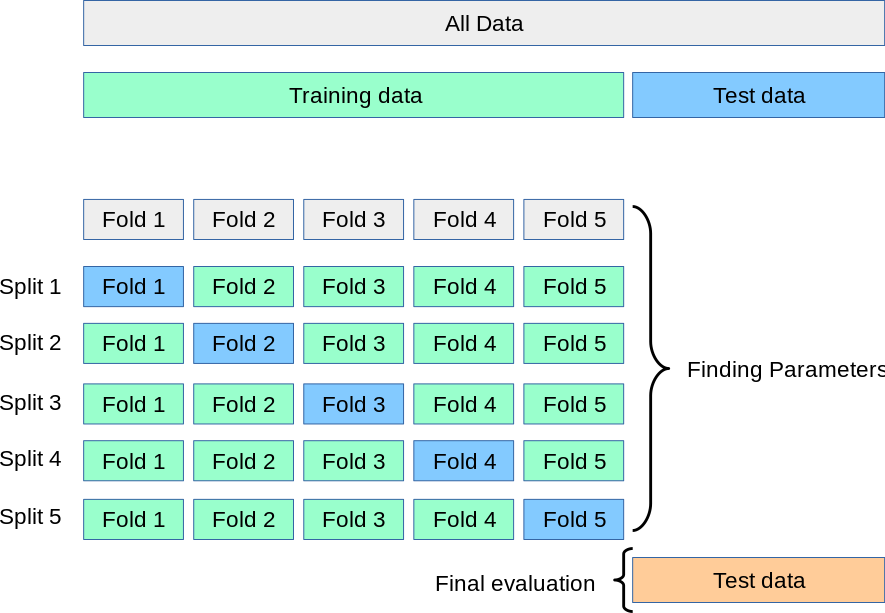)

In [34]:
# Stratified K-Fold交差検証のための関数を定義
def create_folds(df):
    # 'kfold'という新しい列を作成し、初期値として-1を設定
    df['kfold'] = -1

    # データをランダムにシャッフル
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # StratifiedKFoldクラスを初期化
    # StratifiedKFoldは、各フォールドが全体のサンプルのクラスの比率を保持するようにデータを分割
    kf = StratifiedKFold(n_splits=N_SPLITS)

    # 'kfold'列に各データポイントが属するフォールドの番号を設定
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['Y'])):
        df.loc[v_, 'kfold'] = f

    return df

# 'train'データフレームに対して上記の関数を適用
train = create_folds(train)

# 変更後の'train'データフレームを表示
train

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Y,age_standardized,age_normalized,age_log_transformed,workclass_count_encoded,workclass_label_encoded,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_gov,workclass_self_emp,workclass_unstable,native-country_north_america,native-country_europe,native-country_asia,native-country_central_south_america,native-country_label_encoded,education_count_encoded,marital-status_count_encoded,occupation_count_encoded,relationship_count_encoded,race_count_encoded,avg_gain_by_country,kfold
0,27255,36,Private,343476,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,1,0,0,30,United-States,0,-0.190991,0.260274,3.610918,12307,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,38,5296,2190,2994,4182,13923,1106.546555,0
1,3817,50,Private,108933,9th,5,Married-civ-spouse,Craft-repair,Husband,White,1,2885,0,40,United-States,0,0.834710,0.452055,3.931826,12307,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,38,238,7444,2994,6590,13923,1106.546555,0
2,24284,27,Local-gov,221317,11th,7,Married-civ-spouse,Craft-repair,Husband,White,1,0,0,40,Mexico,0,-0.850371,0.136986,3.332205,1037,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,25,595,7444,2994,6590,13923,110.383436,0
3,19804,58,Self-emp-not-inc,331474,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,0,20,United-States,1,1.420825,0.561644,4.077537,1243,5,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,38,5296,7444,1871,749,13923,1106.546555,0
4,15392,57,Private,182028,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,White,0,0,0,40,United-States,0,1.347560,0.547945,4.060443,12307,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,38,2691,7444,2004,749,13923,1106.546555,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,26812,30,Private,46712,HS-grad,9,Divorced,Other-service,Not-in-family,White,0,0,0,40,United-States,0,-0.630578,0.178082,3.433987,12307,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,38,5296,2190,1698,4182,13923,1106.546555,4
16276,10734,83,Private,195507,HS-grad,9,Widowed,Protective-serv,Not-in-family,White,1,0,0,55,United-States,0,3.252434,0.904110,4.430817,12307,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,38,5296,493,332,4182,13923,1106.546555,4
16277,1707,29,Private,82242,Prof-school,15,Never-married,Prof-specialty,Unmarried,White,1,27828,0,45,Germany,1,-0.703842,0.164384,3.401197,12307,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,10,276,5420,2033,1761,13923,1126.328125,4
16278,31602,64,Self-emp-inc,272531,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,1,0,0,40,United-States,1,1.860411,0.643836,4.174387,543,4,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,38,5296,7444,2994,6590,13923,1106.546555,4


In [35]:
# 使用する説明変数のリストを定義
cols = [
    # age
    'age',
    #'age_normalized',
    #'age_normalized',
    #'age_log_transformed',

    # 他の量的変数
    'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
    'hours-per-week',

    # workclass
    'workclass_count_encoded',
    #'workclass_label_encoded',
    #'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
    #'workclass_Never-worked	workclass_Private', 'workclass_Self-emp-inc',
    #'workclass_Self-emp-not-inc', 'workclass_State-gov',
    #'workclass_Without-pay',
    'workclass_gov', 'workclass_self_emp', 'workclass_unstable',

    # sex
    'sex',

    # native-country
    'native-country_north_america', 'native-country_europe',
    'native-country_asia', 'native-country_central_south_america',
    'native-country_label_encoded',

    # 他のカテゴリカル変数
    'education_count_encoded',
    'marital-status_count_encoded', 'occupation_count_encoded',
    'relationship_count_encoded', 'race_count_encoded',

    # 量的変数xカテゴリカル変数
    'avg_gain_by_country',
]

# Stratified K-Fold交差検証のためのループを開始
scores = []  # 各フォールドの精度を保存するリスト
preds = []   # 各フォールドの予測値を保存するリスト
for fold in range(N_SPLITS):
    # データの分割
    tr = train[train['kfold']!=fold]
    val = train[train['kfold']==fold]

    # 説明変数と目的変数を設定
    X_tr = tr[cols]
    y_tr = tr['Y'].values
    X_val = val[cols]
    y_val = val['Y'].values
    X_test = test[cols]

    # LightGBMのモデルを初期化して訓練
    model = lgb.LGBMClassifier(
        max_depth=-1,
        random_state=SEED,
        verbose=-1,
    )
    model.fit(X_tr, y_tr)

    # 検証データに対する予測を行い、精度を計算
    y_val_pred = model.predict_proba(X_val)[:, 1]
    y_val_pred = np.round(y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    scores.append(accuracy)

    print(f'Fold = {fold}, Accuracy = {accuracy:.3f}')

    # テストデータに対する予測を行い、予測値を保存
    y_pred = model.predict_proba(X_test)[:, 1]
    preds.append(y_pred)

# 交差検証で得られた複数のモデルの予測値の平均を計算
pred = np.mean(preds, axis=0)
pred = np.round(pred)
print(f'\nAccuracy = {np.mean(scores):.3f}')

# 最終的な予測値を表示
pred

Fold = 0, Accuracy = 0.867
Fold = 1, Accuracy = 0.862
Fold = 2, Accuracy = 0.869
Fold = 3, Accuracy = 0.874
Fold = 4, Accuracy = 0.871

Accuracy = 0.869


array([0., 1., 0., ..., 1., 0., 0.])

# Submit

In [36]:
# TSVファイルを読み込む
# 注意: ファイルの場所は自分の環境に合わせて修正すること
submit = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/share/train.tsv', sep='\t')

# 'id'列と'Y'列を取得し、列名を0,1に変更
submit = submit[['id', 'Y']]

# 予測結果をデータフレームに変換し、'id'列を追加
pred = pd.DataFrame(pred)
pred = pd.concat([test[['id']], pred], axis=1)
pred.columns = ['id', 'Y']

# 予測結果を数値から文字列に変換
# 1を'>50K'に、0を'<=50K'に変換
pred.loc[:, 'Y'] = pred['Y'].replace({1:'>50K', 0:'<=50K'})

# 既存のデータと予測結果を結合
submit = pd.concat([submit, pred])

# 'id'列でソートし、'id'列を削除
submit = submit.sort_values('id')
submit.drop(columns=['id'], inplace=True)

# インデックスをリセット
submit = submit.reset_index(drop=True)

# 予測結果をCSVファイルとして保存
# header=Falseとすることで、列名を含めずに保存
submit.to_csv('/content/drive/MyDrive/Colab_Notebooks/share/submit.csv', header=False)

# 予測結果のデータフレームを表示
submit

,Y
0,<=50K
1,<=50K
2,>50K
3,<=50K
4,<=50K
...,...
32556,<=50K
32557,<=50K
32558,>50K
32559,<=50K
